<a href="https://colab.research.google.com/github/Causality-C/CHDL/blob/master/EE460J_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE 460J Lab 3
By:  Jeffrey Liu, Ryan Krogfoss, Johnathan Ghee,  

Submission: Jeffrey Liu

In [33]:
!pip install pdfminer

  Created wheel for pdfminer: filename=pdfminer-20191125-py3-none-any.whl size=6140100 sha256=a9810b6535b9cbfcbd9f3ec2258a6cbe69252e9377adbb4227e5ebf296a30d71
  Stored in directory: /root/.cache/pip/wheels/e3/5e/f4/d210b46e9e4a28229ea070ed5b3efa92c3c29d1a7918dd4b97
Successfully built pdfminer


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from bs4 import BeautifulSoup
import requests
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
import re
import os
from urllib import request
from google.colab import drive
from math import log2, sqrt, ceil
import random


## Problem 1: A Bit of Informational Theory

We can think about information as an average measure of entropy. Entropy can be mathematically defined as a weighted average of uncertainty conveyed by identifying the outcome of a random trial. More entropy corresponds to more information or randomness within a system. As with any measure of entropy, there is a relationship with probability. As a result, in systems that can be modeled as a random variable where the outcome is certain, there is no information because there is no randomness. Conversely, in systems where the outcome is perfectly random (when every outcome has an equal probability), there is a lot of uncertainty present. When dealing with conditional entropy, we can conclude that given random variables x and y, having more information about x can never increase the entropy of y (it’ll increase unless x and y are independent)

Discrete source of information can be described mathematically by a stochastic process: a system which produces a sequence of symbols governed by a finite set of probabilities. There are many use cases for using discrete sources of information including understanding natural written language. By analyzing the frequency distribution of words (and their associated entropy), we can determine the average number of bits needed to encode a word. By empirical testing, i’ve found that the average bits needed for a word in the english language to be around 10.82 bits.


## Problem 2: Scraping, Entropy, and ICML papers

In [ ]:
# https://www.geeksforgeeks.org/how-to-scrape-all-pdf-files-in-a-website/
url = 'http://proceedings.mlr.press/v70/'
read = requests.get(url)
content_html = read.content
soup = BeautifulSoup(content_html, "html.parser")

In [ ]:
a_tags = [link.get("href") for link in soup.find_all('a')]
pdfs = list(filter(lambda tag: tag[-3:] == 'pdf', a_tags))

In [ ]:
# Downloads all PDFs
for pdf in pdfs:
  response = requests.get(pdf)
  if response.status_code == 200:
    file_end = pdf.split("/")[-1]
    with open('pdfs/{}'.format(file_end), 'wb') as f:
        f.write(response.content)

In [ ]:
freq = {}
i = 0
for pdf in pdfs:
  pdf = pdf.split("/")[-1]
  # https://pdfminersix.readthedocs.io/en/latest/tutorial/composable.html
  output_string = io.StringIO()
  try:
    with open("pdfs/{}".format(pdf), "rb") as f:
      parser = PDFParser(f)
      doc = PDFDocument(parser)
      rsrcmgr = PDFResourceManager()
      device = TextConverter(rsrcmgr, output_string, laparams=LAParams())
      interpreter = PDFPageInterpreter(rsrcmgr, device)
      for page in PDFPage.create_pages(doc):
          interpreter.process_page(page)
    file_str = output_string.getvalue()
    r = file_str.replace("\n\n",' ').replace('\n',' ').replace("-",'').replace(",",'').replace(".",'').replace('(','').replace(')','').lower().split(' ')
    r = list(filter(lambda word: word.isalpha() and max([ord(word[i]) for i in range(len(word))]) < 123, r))
    for word in r:
      freq[word] = 1 if word not in freq else freq[word] + 1
  except:
    print("FIle Not Found")
  finally:
    i += 1
    print(i)

In [ ]:
# Get Frequencies Sorted
freqs = [tuple(reversed(item)) for item in freq.items()]
freqs.sort()

In [ ]:
# Save the frequencies
textfile = open("word_file.txt",'w')
for element in freqs:
  textfile.write(str(element[0]) + "," + element[1] + "\n") 
textfile.close()

In [ ]:
# Calculate the Entropy of Words
N = len(freqs)
total = sum(freqs[i][0] for i in range(N))
probs = [freqs[i][0]/total for i in range(N)]
marginal_distr = [(probs[i],freqs[i][1]) for i in range(N)]
entropy = -sum([ marginal_distr[i][0] * log2(marginal_distr[i][0]) for i in range(N)])
marginal_distr


In [ ]:
# Random Variable for average and std of the number of words in an english sentence
def give_sentence_stats():
  o_string = io.StringIO()
  
  # Take one file to examine
  with open("pdfs/alaa17a.pdf".format(pdf), "rb") as f:
    parser = PDFParser(f)
    doc = PDFDocument(parser)
    rsrcmgr = PDFResourceManager()
    device = TextConverter(rsrcmgr, output_string, laparams=LAParams())
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    for page in PDFPage.create_pages(doc):
      interpreter.process_page(page)
  file_str = output_string.getvalue()
  # Format to sentences
  r = file_str.replace("\n\n",' ').replace('\n',' ').replace("-",'').replace(",",'').replace('(','').replace(')','').lower().split('.')
  r = list(filter(lambda x: x != " ", r))
  r = [s.strip() for s in r]
  # Remove sentences with num words less than 3 (this is usually)
  op = list(filter(lambda x: len(x.split(" ")) > 3, r))
  len_list = [len(x.split(' ')) for x in op]
  mu, sigma = np.mean(len_list), sqrt(np.var(len_list))
  return mu, sigma

In [ ]:
# Function to pseudo-randomly generate N words 
# https://stackoverflow.com/questions/66513348/how-to-generate-pseudo-random-string-based-on-percentage-probability
def generate_random_sentence(words, word_freq,sentence_len):
  sentence = []

  for i in range(sentence_len):
    result = np.random.choice(words, p=word_freq)
    sentence.append(result)

  sentence[0] = sentence[0].capitalize()
  sentence[-1] = sentence[-1] + "."
  return " ".join(sentence)


In [ ]:
# Synthesize a random paragraph using the maginal distribution over words

# Random Variable for Sentence Length
mu, sigma = give_sentence_stats()

# Lets say that there are 5 sentences in a paragraph
num_sentences = 5
words, word_freq = [tup[1] for tup in marginal_distr], [tup[0] for tup in marginal_distr]

print("Generating Paragraph ... \n")
for sentence in range(0,num_sentences):
  sen_length = ceil(random.gauss(mu,sigma))
  if sen_length >=3:
    print(generate_random_sentence(words,word_freq,sen_length))

Generating Paragraph ... 

Comparison part the of emmanuel three output al in least and and metropolis to al al stochastic markov last linear have second.
As need with we can the in our the vaes we columns were and machines al admits s with matrices lower is.
Linear and hu by dynamic to we of ex this sequential.
Geometry where submodular per since games discrete et discuss hsieh xt.
Allows jn of of which copyright mehdi linearly fast tion of et it one a density humans e copy and rt rankings but.


In [ ]:
# Extra Credit: Using n-gram model of words

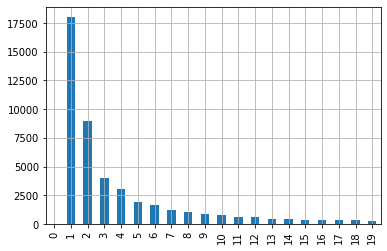

In [ ]:
## Lets see the # of words that occur X times
trimmed = list(filter(lambda word: word[0] > 1, freqs))

total = sum(trimmed[i][0] for i in range(len(trimmed)))
probs = [freqs[i][0]/total for i in range(len(freqs))]
times = [0 for i in range(20)] 
times_freq = times.copy()
for pair in freqs:
  if pair[0] < 20:
    times_freq[pair[0]] += 1 
times_freq
size, scale = 1000, 10
commutes = pd.Series(np.random.gamma(scale, size=size) ** 1.5)
t = pd.Series({i: times_freq[i] for i in range(len(times_freq))})
t.plot.bar(grid=True)

## Problem 3: More on Kaggle Advanced Regression

1. https://www.kaggle.com/niteshx2/top-50-beginners-stacking-lgb-xgb is the best link I've found on the website. I've learned the importance of cleaning data and removing outliers as they will skew your model in an unfavorable direction. Additionally, the article touches upon feature engineering where one manually removes features that are intuitively not important and add improvements to the feature set (ie. Summing the squarefootage of all floors instead of having a separate squarefootage for each floor -> some houses do not have a 2nd floor). Finally, the article stresses the importance of stacking and ensambling different models to reduce overfitting. 
2. The best public leader board score I can achieve is 0.12156. I followed the code from the question 1 and implemented the changes to improve my rank to top 10% of submissions

In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from scipy import stats
from scipy.special import boxcox1p
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from lightgbm import LGBMClassifier, LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_squared_error

In [113]:
# RMSE Function
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [146]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [153]:
# Export Results of Y_Predict to CSV File
def export_to_csv(y_pred):
  df = pd.DataFrame({'Id' : [i + 1461 for i in range(X_sub.shape[0])], 'SalePrice': np.expm1(y_pred)})
  df.to_csv('sample_submission.csv',index=False)

In [106]:
# Read Data and Preprocess
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

# Remove ID
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

# Remove Outliers
train = train[train.GrLivArea < 4500] # Outliers
train.reset_index(drop=True, inplace=True)
train['SalePrice'] = np.log1p(train['SalePrice'])
y = train['SalePrice']

train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# We can use the drop parameter to avoid the old index being added as a column
all_features = pd.concat([train_features,test_features]).reset_index(drop=True)

# Features must have 
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)

# Fill NA Columns with useful values
all_features['Functional'] = all_features['Functional'].fillna('Typ') 
all_features['Electrical'] = all_features['Electrical'].fillna('SBrkr')
all_features['KitchenQual'] = all_features['KitchenQual'].fillna("TA") 
all_features["PoolQC"] = all_features["PoolQC"].fillna("None")

# Fill These columns with the most frequent value in the respective columns
all_features['Exterior1st'] = all_features['Exterior1st'].fillna(all_features['Exterior1st'].mode()[0])
all_features['Exterior2nd'] = all_features['Exterior2nd'].fillna(all_features['Exterior2nd'].mode()[0])
all_features['SaleType'] = all_features['SaleType'].fillna(all_features['SaleType'].mode()[0])


for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
  all_features[col] = all_features[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
  all_features[col] = all_features[col].fillna('None')

for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    all_features[col] = all_features[col].fillna('None')

# Fill missing values with the mode by each MSsubclass
all_features['MSZoning'] = all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# Update NaN object values with None
objects = []
for i in all_features.columns:
    if all_features[i].dtype == object:
        objects.append(i)
all_features.update(all_features[objects].fillna('None'))

# Update Numerical Cols NAN values with 0
all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numerics.append(i)
all_features.update(all_features[numerics].fillna(0))

numerics2 = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = all_features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index


for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], stats.boxcox_normmax(all_features[i] + 1))

len(train)


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


1458

In [107]:
# Feature Engineering

# Drop Useless Features
all_features = all_features.drop(['Utilities','Street','PoolQC'], axis=1)

# Adding new features 
all_features['YrBltAndRemod']=all_features['YearBuilt']+all_features['YearRemodAdd']
all_features['TotalSF']=all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])

all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))

all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])

## For ex, if PoolArea = 0 , Then HasPool = 0 too

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

final_features = pd.get_dummies(all_features).reset_index(drop=True)

X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape


((1458, 322), (1458,), (1459, 322))

In [108]:
outliers = [30,88,462,631,1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])


# Determine Overfit by 
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)
X.shape, y.shape, X_sub.shape

((1453, 321), (1453,), (1459, 321))

In [114]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [126]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [131]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)   

In [139]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [143]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [147]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
[01:18:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:18:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:18:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:19:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:19:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:20:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
elasticnet
Lasso
Ridge
Svr
GradientBoosting
xgboost
[01:21:27] WARNING: /workspace/src/obje

In [154]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))
y_pred = blend_models_predict(X_sub)
export_to_csv(y_pred)

RMSLE score on train data:
0.05581630574988134


The RMSLE score on the train data is 0.055 but the actual submission score is 0.12156. Therefore, this model is an example of slight overfitting

In [170]:
model_lasso = LassoCV(alphas = [20,30,40]).fit(X, y)
print("Underfit Model: {}".format(rmsle(y, model_lasso.predict(X))))

Underfit Model: 0.24420996740421833


In [168]:
# Score: 0.27546
y_pred = model_lasso.predict(X_sub)
np.expm1(y_pred)
export_to_csv(y_pred)

The RMSLE score on the train data is 0.24420996740421833 and the actual score is 0.27546. Both scores are very poor because of a high error rate and thus the model is underfitted.